In [1]:
import json
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch
from model_timm import TimmClassificationModel
from src.data import DataModule
import torch.nn as nn
import seaborn as sns

/mnt/share/agiuser/luojiawen/miniconda3/envs/l2p/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SaveAttMaps(nn.Module):
    def __init__(self):
        super().__init__()
        self.curr_att_maps = None
        self.Q = None
        self.K = None
        self.V = None
        self.out = None
        self.out_pre_res = None

    def forward(self, X, Q, K, V):
        self.curr_att_maps = nn.Parameter(X)
        self.Q = nn.Parameter(Q)
        self.K = nn.Parameter(K)
        self.V = nn.Parameter(V)

        return X

In [4]:
test_data = DataModule(dataset='dtd', root='/mnt/share/agiuser/qiuzihan/data')

Using the dtd dataset


In [5]:
test_data.prepare_data()
test_data.setup(stage='test')

In [6]:
test_data.setup(stage='test')

In [7]:
test_data_loader = test_data.test_dataloader()

In [8]:
net = TimmClassificationModel.load_from_checkpoint(checkpoint_path='/mnt/share/agiuser/qiuzihan/VIT/output/dtd/0515/tune_headFalse/tune_clsTrue/HMA/HMA_update_label_hidden_64_abd_True_Rmem_128_Smem8_gaussain_True_topk_16_logitsall_norm_False_softmax_temp1.0_mom0.999_nullFalse_lr0.003_seed0/version_0/checkpoints/best-epoch=44-val_acc=0.7500.ckpt',)

loading from /mnt/share/agiuser/qiuzihan/VIT/pretrained_ckpt/vit_base_patch32_224.augreg_in21k.pth
using HMA
Info: dim_out == dim_Q. Using Identity transform
Info: dim_out == dim_Q. Using Identity transform
using gaussain memory
using 128 local memory; 47*8 global memory; logits from all
padding index 47, embedding number 48
tuning global_memories
tuning label_embeddings.weight
tuning encoder.cls_token
tuning encoder.pos_embed
tuning encoder.patch_embed.proj.weight
tuning encoder.patch_embed.proj.bias
tuning encoder.blocks.0.norm1.weight
tuning encoder.blocks.0.norm1.bias
tuning encoder.blocks.0.attn.qkv.weight
tuning encoder.blocks.0.attn.qkv.bias
tuning encoder.blocks.0.attn.proj.weight
tuning encoder.blocks.0.attn.proj.bias
tuning encoder.blocks.0.norm2.weight
tuning encoder.blocks.0.norm2.bias
tuning encoder.blocks.0.mlp.fc1.weight
tuning encoder.blocks.0.mlp.fc1.bias
tuning encoder.blocks.0.mlp.fc2.weight
tuning encoder.blocks.0.mlp.fc2.bias
tuning encoder.blocks.1.norm1.weight
tu

In [11]:
net.net.local_read_block.mab.debug_mode = True
net.net.ABD_block.mab.debug_mode = True

In [9]:
net.net.local_read_block.mab.viz_att_maps = True
net.net.local_read_block.mab.save_att_maps = SaveAttMaps()

net.net.ABD_block.mab.viz_att_maps = True
net.net.ABD_block.mab.save_att_maps = SaveAttMaps()

In [10]:
net.to('cuda')

TimmClassificationModel(
  (net): HMA(
    (label_embeddings): Embedding(48, 64)
    (encoder): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in

In [11]:
images_dic, labels = {}, []
for data in test_data_loader:
    temp_images, temp_labels = data
    for image, label in zip(temp_images, temp_labels):
        if label.item() not in images_dic.keys():
            images_dic.update({label.item(): [image]})
        else:
            images_dic[label.item()].append(image)

In [14]:
test_images = []
test_labels = []
for i in range(10):
    test_images.extend(images_dic[i][:10])
    test_labels.extend([i] * 10)
test_images = torch.stack(test_images)
test_labels = torch.tensor(test_labels)

In [16]:
image_features = net(test_images.to('cuda'))

viz raw att maps
viz processed att maps
viz raw att maps
viz processed att maps


In [17]:
read_block_att = net.net.local_read_block.mab.save_att_maps
Abd_block_att = net.net.ABD_block.mab.save_att_maps

In [18]:
def grid_show(to_shows, cols, save_image=False):
    rows = (len(to_shows)-1) // cols + 1
    it = iter(to_shows)
    fig, axs = plt.subplots(rows, cols, figsize=(rows*8.5, cols*2))
    for i in range(rows):
        for j in range(cols):
            try:
                image, title = next(it)
            except StopIteration:
                image = np.zeros_like(to_shows[0][0])
                title = 'pad'
            axs[i, j].imshow(image)
            axs[i, j].set_title(title)
            axs[i, j].set_yticks([])
            axs[i, j].set_xticks([])
    if save_image:
        plt.savefig('heads_attn.pdf', bbox_inches='tight',pad_inches = 0)
    plt.show()

def visualize_head(att_map):
    ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(att_map)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    plt.show()
    
def visualize_heads(att_map, cols, save_image=False):
    to_shows = []
    att_map = att_map.squeeze()
    for i in range(att_map.shape[0]):
        to_shows.append((att_map[i], f'Head {i}'))
    average_att_map = att_map.mean(axis=0)
    to_shows.append((average_att_map, 'Head Average'))
    grid_show(to_shows, cols=cols, save_image=save_image)

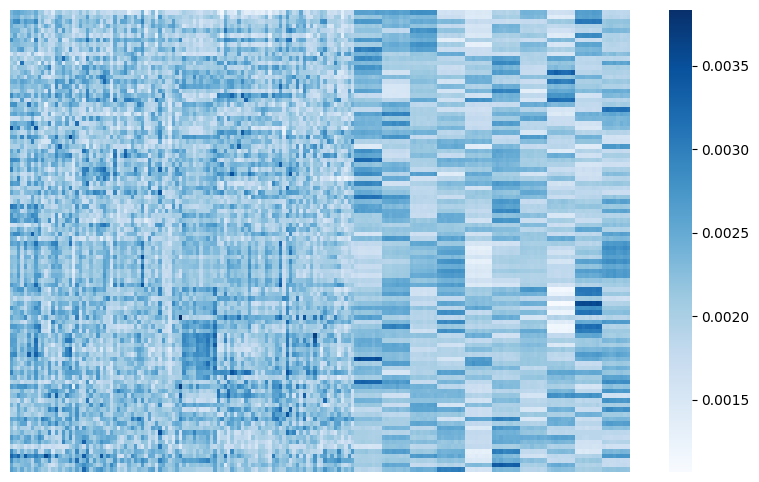

In [28]:
plt.figure(dpi=100, figsize=(10,6))
ax=sns.heatmap(data=Abd_block_att.processed_att[0, :, :180].cpu().detach().numpy(),
            cmap=plt.get_cmap('Blues'),
            # yticklabels=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90],
            xticklabels=False,
            yticklabels=False,
            cbar=True,
            
            )
plt.savefig('dtd_attention_10class.pdf',bbox_inches='tight',pad_inches=0.0)